In [ ]:
#import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import albumentations as A
from tqdm import tqdm
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#read the test file
df = pd.read_csv("test.csv")
df.head()

,drawing,key_id
0,"[[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...",4635484858875904
1,"[[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...",5954439485587456
2,"[[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...",4703897211895808
3,"[[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...",4614697670148096
4,"[[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...",5669598810603520


In [ ]:
df.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185439 entries, 0 to 185438
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   drawing  185439 non-null  object
 1   key_id   185439 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 98.7 MB


In [ ]:
#use the functions provided by the team to get the image
from PIL import Image, ImageDraw
import numpy as np
import json

def vector_to_numpy(drawing, side=256):
    image = vector_to_image(drawing, side)
    image_array = np.array(image)
    return image_array

def vector_to_image(drawing, side=256):
    drawing = json.loads(drawing)
    min_x, min_y, max_x, max_y = calculate_bounding_box(drawing)

    # Calculate the offset to center the drawing within the canvas
    offset_x = (side - (max_x - min_x + 1)) // 2
    offset_y = (side - (max_y - min_y + 1)) // 2

    image = Image.new('L', (side, side), color='white')  # Create a white canvas
    draw = ImageDraw.Draw(image)

    for x, y in drawing:
        xy = [(x0 - min_x + offset_x, y0 - min_y + offset_y) for x0, y0 in zip(x, y)]
        draw.line(xy, fill='black', width=1)

    return image
def calculate_bounding_box(drawing):
    all_x = [x for x, _ in drawing]
    all_y = [y for _, y in drawing]

    min_x = min(min(x) for x in all_x)
    min_y = min(min(y) for y in all_y)
    max_x = max(max(x) for x in all_x)
    max_y = max(max(y) for y in all_y)

    return min_x, min_y, max_x, max_y

In [ ]:
#transforms
IMAGE_HEIGHT = 256
IMAGE_WIDTH  = 256
train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

In [ ]:
#creating a dataset
class test_images(Dataset):
    def __init__(self,X,transform):
        self.dataframe = X
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        train_image = vector_to_numpy(self.dataframe.iloc[idx]["drawing"])
        train_image = 1 - self.transform(image = train_image)["image"].reshape((1,256,256))   #.to(DEVICE)
        return train_image



In [ ]:
#feed forward neural network
class Custom_nn(nn.Module):
    def __init__(self,Net_size = 256,input_shape = 512, output_shape =101):
        super().__init__()
        self.nn = nn.Sequential(nn.Linear(input_shape,Net_size),nn.Tanh(),
                                nn.Linear(Net_size,output_shape))

    def forward(self,input):
        return (self.nn(input))


In [ ]:
#Encoder part of U-Net
class UNetEncoder(nn.Module):
    def __init__(self, in_channels, bottleneck_channels):
        super(UNetEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=9, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=7, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv1 = self.conv_block(64, 128)
        self.conv2 = self.conv_block(128, 256)
        self.conv3 = self.conv_block(256, 512)
        self.conv4 = self.conv_block(512, bottleneck_channels)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.conv1(x1)
        x3 = self.conv2(x2)
        x4 = self.conv3(x3)
        x5 = self.conv4(x4)
        return x5

In [ ]:
#defining our final model that is similar to our train model
in_channels = 1  # gray scale image
bottleneck_channels = 512  # the bottleneck has 512 feature maps
encoder = UNetEncoder(in_channels, bottleneck_channels)
model_custom = Custom_nn(input_shape = 512)
class final_model_unet(nn.Module):
    def __init__(self,encoder,model_custom):
        super().__init__()
        self.model1    = encoder
        self.model2    = model_custom

    def forward(self,input):

        out = self.model1(input)
        out = self.model2(out.reshape(out.shape[0],out.shape[1]*out.shape[2]*out.shape[3]))
        return out

model_final_unet = final_model_unet(encoder,model_custom)
model_final_unet

final_model_unet(
  (model1): UNetEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2):

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-5
model = model_final_unet.to(DEVICE)

In [ ]:
#creating a dataset
class test_images(Dataset):
    def __init__(self,X,transform):
        self.dataframe = X
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        train_image = vector_to_numpy(self.dataframe.iloc[idx]["drawing"])
        train_image = 1 - self.transform(image = train_image)["image"].reshape((1,256,256))   #.to(DEVICE)
        return train_image


In [ ]:
test_dataset = test_images(df, val_transform)


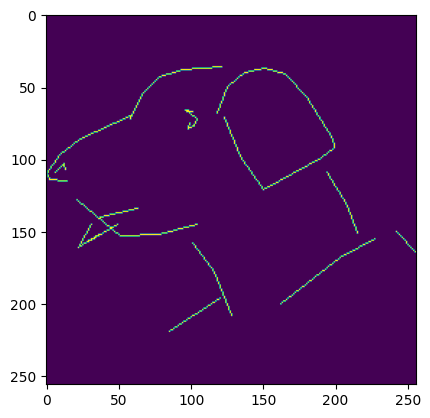

In [ ]:
img = test_dataset.__getitem__(0)
plt.imshow(img.numpy().reshape(256,256))

In [ ]:
#load the state dictionary of the trained model
model.load_state_dict(torch.load("model_final_400am.pth"))
model


final_model_unet(
  (model1): UNetEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2):

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185439 entries, 0 to 185438
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   drawing  185439 non-null  object
 1   key_id   185439 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ MB


In [ ]:
#test if test dataset is working
out = model(test_dataset.__getitem__(0).to(DEVICE).reshape(1,1,256,256))
out.flatten()

tensor([-0.4370,  0.9123, -0.7960, -1.3521, -0.3900, -1.9458, -1.2216, -1.4774,
         4.7573, -2.3611,  1.2906,  1.0344, -1.5657, -1.6806,  0.8239,  1.5189,
        -1.1335,  2.4950, -2.0327, -0.8832,  0.8243,  1.3350,  2.2764, -0.1241,
        -1.1867, -1.1376,  2.8779, -0.7048,  0.2454,  1.3152, -0.8046, -0.0442,
         4.2030, -0.7938, -0.6514,  0.6330, -1.9850, -1.1071, -0.7283,  1.9673,
         1.2786, -0.6912,  0.0910,  1.2336, -1.4553,  0.2890, -2.2572, -3.5806,
         0.2029, -1.2283, -0.4146, -0.4239,  2.2051, -0.0436, -1.3917, -0.2563,
        -1.4897,  1.3408, -2.3180,  2.3103,  0.6812,  2.0212,  1.2088, -0.4790,
         2.4796,  2.7163, -1.3910,  3.4473,  0.2661, -1.6792,  2.3087, -2.4286,
        -1.8163,  1.6211, -0.7220, -0.6666, -0.8663,  0.1117, -1.4678, -1.0415,
         2.5229,  0.3864, -1.2869, -0.5930, -0.1737, -0.1460, -0.4799,  0.6290,
        -0.9014,  4.2183, -0.7912, -1.3624, -0.7447,  0.1487, -1.3452,  0.5823,
        -0.4442, -2.2028, -1.4048, -0.20

In [ ]:
#getting the encoded labels
dict_ = {46: 'hot_dog',
 39: 'hand',
 87: 't-shirt',
 10: 'bowtie',
 79: 'purse',
 42: 'helmet',
 35: 'grapes',
 1: 'anvil',
 7: 'bench',
 86: 'sword',
 17: 'dog',
 11: 'brain',
 19: 'door',
 68: 'pear',
 20: 'drill',
 85: 'snail',
 98: 'whale',
 14: 'bulldozer',
 50: 'leaf',
 90: 'telephone',
 58: 'microwave',
 48: 'ladder',
 99: 'wine_bottle',
 41: 'helicopter',
 34: 'golf_club',
 95: 'triangle',
 53: 'line',
 32: 'frog',
 40: 'headphones',
 67: 'parrot',
 69: 'pencil',
 71: 'piano',
 54: 'lipstick',
 56: 'mailbox',
 38: 'hammer',
 70: 'penguin',
 63: 'nail',
 94: 'toaster',
 88: 'table',
 97: 'watermelon',
 31: 'fork',
 47: 'keyboard',
 72: 'picture_frame',
 37: 'hamburger',
 66: 'paper_clip',
 3: 'axe',
 60: 'mountain',
 0: 'ambulance',
 100: 'zigzag',
 26: 'fire_hydrant',
 24: 'eraser',
 15: 'butterfly',
 22: 'elephant',
 5: 'baseball_bat',
 30: 'flip_flops',
 8: 'bird',
 55: 'lollipop',
 77: 'popsicle',
 81: 'rain',
 44: 'hockey_stick',
 23: 'envelope',
 76: 'pizza',
 21: 'ear',
 89: 'teddy-bear',
 64: 'octagon',
 61: 'mouse',
 9: 'book',
 4: 'banana',
 62: 'mushroom',
 73: 'pig',
 12: 'bread',
 33: 'garden_hose',
 29: 'flamingo',
 59: 'mosquito',
 2: 'apple',
 65: 'owl',
 16: 'diving_board',
 57: 'mermaid',
 75: 'pineapple',
 49: 'laptop',
 82: 'rainbow',
 28: 'fish',
 13: 'bridge',
 78: 'potato',
 6: 'bed',
 92: 'tent',
 51: 'leg',
 96: 'truck',
 43: 'hexagon',
 83: 'remote_control',
 45: 'hot_air_balloon',
 27: 'fireplace',
 91: 'television',
 52: 'lightning',
 36: 'guitar',
 74: 'pillow',
 25: 'eye',
 80: 'rabbit',
 93: 'tiger',
 84: 'river',
 18: 'donut'}

In [ ]:
len(list(dict_.keys()))

101

In [ ]:
#custom function to write the labels to the output file
def str_(a):
  st = ""
  for i in a:
    st += (dict_[i]+" ")
  st = st[:-1]
  return st

In [ ]:
#test code to check if the custom function is working fine
out = model(test_dataset.__getitem__(0).to(DEVICE).reshape(1,1,256,256))
out = torch.topk(out.flatten(), 3).indices.detach().cpu().numpy()
str_(out)

'bird teddy-bear frog'

In [ ]:
df.iloc[9]["drawing"]

'[[[145, 123, 98, 75, 39, 9, 3, 0, 0, 12, 39, 84, 98, 122, 143, 196], [255, 247, 223, 199, 151, 100, 83, 67, 24, 9, 0, 1, 7, 27, 49, 122]]]'

In [ ]:
df["word"]  = [None]*len(df)

In [ ]:
df

,drawing,key_id,word
0,"[[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...",4635484858875904,None
1,"[[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...",5954439485587456,None
2,"[[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...",4703897211895808,None
3,"[[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...",4614697670148096,None
4,"[[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...",5669598810603520,None
...,...,...,...
185434,"[[[121, 101, 56, 24, 5, 0, 3, 21, 63, 132, 174...",4893585587568640,None
185435,"[[[49, 76, 133], [255, 246, 242]], [[98, 98, 8...",6040905817522176,None
185436,"[[[54, 48, 44, 28, 9, 3, 0, 10, 46, 56], [51, ...",4607485933518848,None
185437,"[[[27, 8, 2, 0, 12, 25, 38, 45, 61, 72, 77, 70...",5693868500582400,None


In [ ]:
#getting the test predictions
for i in range(len(df)):
  if i%10000 == 0:
    print(df.head(5))
  out = model(test_dataset.__getitem__(i).to(DEVICE).reshape(1,1,256,256))
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())

                                             drawing            key_id   word
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904  isdhb
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   None
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   None
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   None
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   None


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


                                             drawing            key_id  \
0  [[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...  4635484858875904   
1  [[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...  5954439485587456   
2  [[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...  4703897211895808   
3  [[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...  4614697670148096   
4  [[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...  5669598810603520   

                       word  
0      bird teddy-bear frog  
1        elephant dog tiger  
2           penguin owl ear  
3  purse helmet garden_hose  
4   mermaid guitar elephant  


<ipython-input-94-d80cb9d71fa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word"][i] = str_(torch.topk(out.flatten(), 3).indices.detach().cpu().numpy())


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185439 entries, 0 to 185438
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   drawing  185439 non-null  object
 1   key_id   185439 non-null  int64 
 2   word     185439 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.2+ MB


In [ ]:
df.drop(columns = ["key_id"], axis =1 ,inplace  = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185439 entries, 0 to 185438
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   drawing  185439 non-null  object
 1   word     185439 non-null  object
dtypes: object(2)
memory usage: 2.8+ MB


In [ ]:
#saving the csv file
df.to_csv("me19b190_dd.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185439 entries, 0 to 185438
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   drawing  185439 non-null  object
 1   word     185439 non-null  object
dtypes: object(2)
memory usage: 2.8+ MB


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
df_ = pd.read_csv("test.csv")
df_.head()

,drawing,key_id
0,"[[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...",4635484858875904
1,"[[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...",5954439485587456
2,"[[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...",4703897211895808
3,"[[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...",4614697670148096
4,"[[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...",5669598810603520


In [ ]:
df["key_id"] = df_["key_id"]
df.drop(columns = ["drawing"],axis = 1, inplace = True)
df.head()

,word,key_id
0,bird teddy-bear frog,4635484858875904
1,elephant dog tiger,5954439485587456
2,penguin owl ear,4703897211895808
3,purse helmet garden_hose,4614697670148096
4,mermaid guitar elephant,5669598810603520


In [ ]:
df.to_csv('/content/gdrive/My Drive/dd_me19b190.csv', index=False)


In [ ]:
df_["word"] = df["word"]
df_.head()

,drawing,key_id,word
0,"[[[99, 98, 102, 104, 96, 101], [39, 43, 41, 36...",4635484858875904,bird teddy-bear frog
1,"[[[149, 149, 164, 163, 155, 131, 127, 91, 78, ...",5954439485587456,elephant dog tiger
2,"[[[124, 80, 66, 54, 35, 22, 17, 17, 26, 44, 50...",4703897211895808,penguin owl ear
3,"[[[24, 31, 23, 21, 36, 56, 87, 119, 142, 162, ...",4614697670148096,purse helmet garden_hose
4,"[[[73, 73, 78, 103, 114, 120, 122, 112, 97, 84...",5669598810603520,mermaid guitar elephant


In [ ]:
df = df_.drop(columns = ["drawing"],axis = 1)
df.head()

,key_id,word
0,4635484858875904,bird teddy-bear frog
1,5954439485587456,elephant dog tiger
2,4703897211895808,penguin owl ear
3,4614697670148096,purse helmet garden_hose
4,5669598810603520,mermaid guitar elephant


In [ ]:
#Saving the final csv file asked in the given format
df.to_csv('/content/gdrive/My Drive/final_dd_me19b190.csv', index=False)
